# 06 Custom Kernels and Mean Functions

_[Estimated execution time: 1 min]_

In this tutorial we show how custom kernels can be trained with this toolkit as well as how we can train a mean function for our data set. We create an artificial data set, we show how to define a trainable mean function and how to seperate training of the mean function and the kernel.

In [1]:
import mogptk
import torch
import numpy as np

torch.manual_seed(1);

Let's create a function that is periodical and add a polynomial. In this case we choose a sinusoidal with unit frequency and a second-degree polynomial $2.0x - 0.2x^2$.

Remark that loading a `Data` object using `mogptk.LoadFunction` allows us to know the "true" signal to which we add a random variance. This is useful for plotting and also for calculating the "true" prediction error.

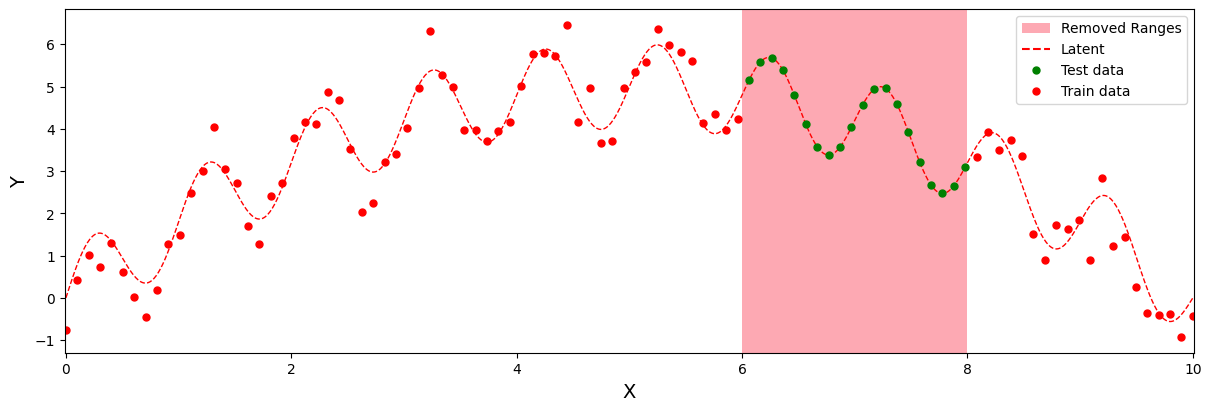

In [2]:
f = lambda x: np.sin(x*2.0*np.pi) + 2*x - 0.2*x**2
data = mogptk.LoadFunction(f, start=0.0, end=10.0, n=100, var=0.5)
data.remove_range(start=6.0, end=8.0)
data.plot();

In order to make a trainable mean function where the parameters are automatically picked up by [`model.train`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.Model.train), we need to create a new class and derive from [`mogptk.gpr.Mean`](https://games-uchile.github.io/mogptk/gpr/mean.html#mogptk.gpr.mean.Mean). In `__init__` we need to call the base class' initializer and then add parameters by assigning instantiations of [`mogptk.gpr.Parameter`](https://games-uchile.github.io/mogptk/gpr/parameter.html#mogptk.gpr.parameter.Parameter) to the class' properties.

The `__call__` function is called to evaluate the mean function and gets passed an `X` of shape `(data points,input dims)` and should returns the Y values of shape `(datapoints,)`. Make sure to "call" your parameters before using: `coefs = self.coefs()`!

In [3]:
class Mean(mogptk.gpr.Mean):
    def __init__(self):
        super(Mean, self).__init__()        
        self.coefficients = mogptk.gpr.Parameter([0.0, 0.0, 0.0])
    
    def __call__(self, X):
        coefs = self.coefficients()
        return coefs[0] + coefs[1]*X[:,1] + coefs[2]*X[:,1]**2

We initialize our mean function, create a periodic kernel, and initialize our model. See all implemented [single output](https://games-uchile.github.io/mogptk/gpr/singleoutput.html) and [multi output](https://games-uchile.github.io/mogptk/gpr/multioutput.html) kernels. Note that we need to create an [`IndependentMultiOutputKernel`](https://games-uchile.github.io/mogptk/gpr/multioutput.html#mogptk.gpr.multioutput.IndependentMultiOutputKernel) to handle the multi-output nature of MOGPTK, even though in this case we have only one channel.

In this case, the random initialization of the parameters of the periodic kernel may give poor results. Setting reasonable values allows training to properly optimize the kernel.

In [4]:
mean = Mean()
kernel = mogptk.gpr.PeriodicKernel(input_dims=1)
mo_kernel = mogptk.gpr.IndependentMultiOutputKernel(kernel)
model = mogptk.Model(data, mo_kernel, mean=mean, name="Periodic")

# initialize kernel parameters to reasonable values
kernel.lengthscale.assign(1.0)
kernel.period.assign(1.0)

We will first only train the mean function, then the kernel, and then both the mean function and the kernel. Note that we can set `train` for kernels, means, and individual parameters to enable or disable training.

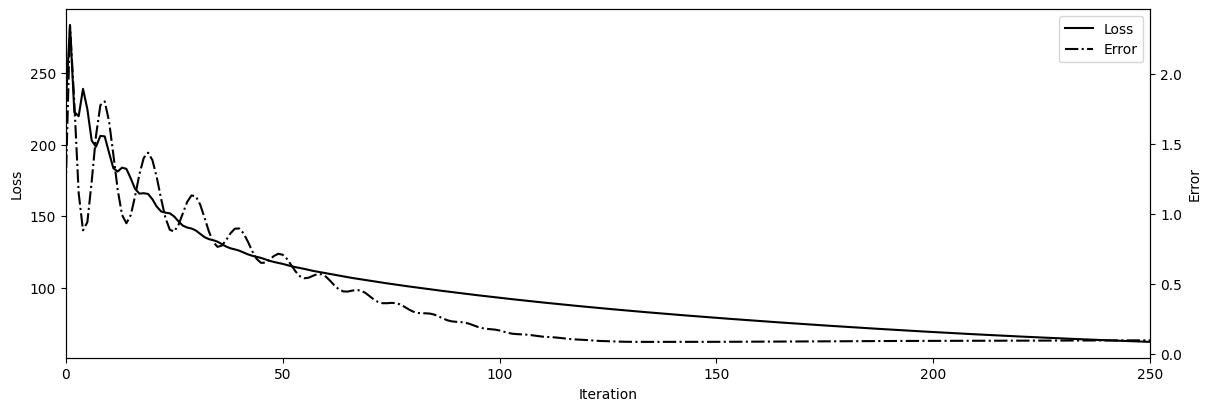

In [5]:
mean.train = True
kernel.train = False
model.train(method='Adam', lr=0.05, iters=250, plot=True, error='MAE');

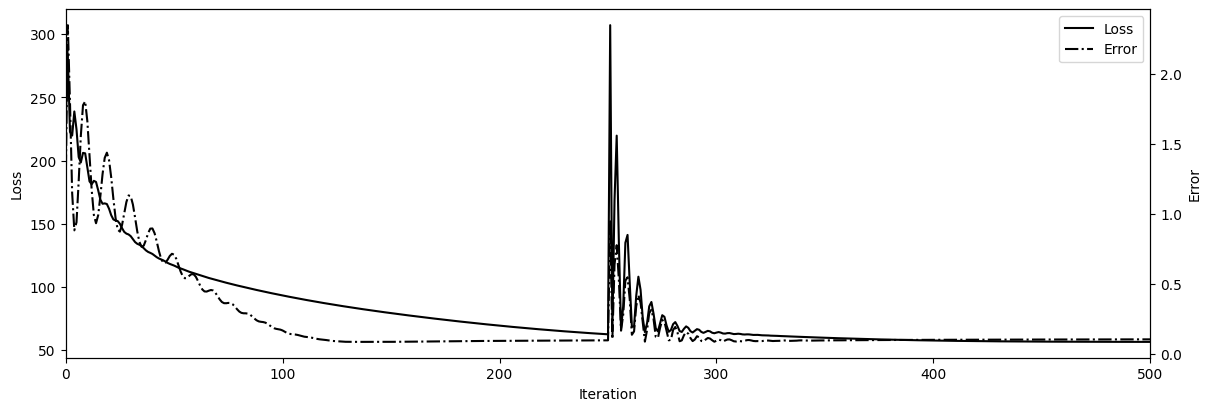

In [6]:
mean.train = False
kernel.train = True
model.train(method='Adam', lr=0.05, iters=250, plot=True, error='MAE');

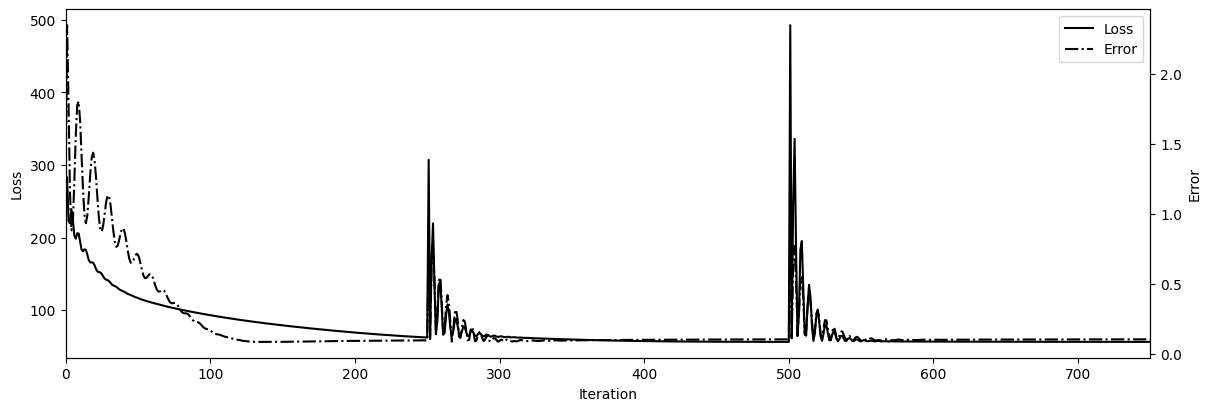

In [7]:
mean.train = True
kernel.train = True
model.train(method='Adam', lr=0.05, iters=250, plot=True, error='MAE');

,MAE,MAPE,RMSE
Name,,,
Periodic,0.104703,2.493691,0.140321


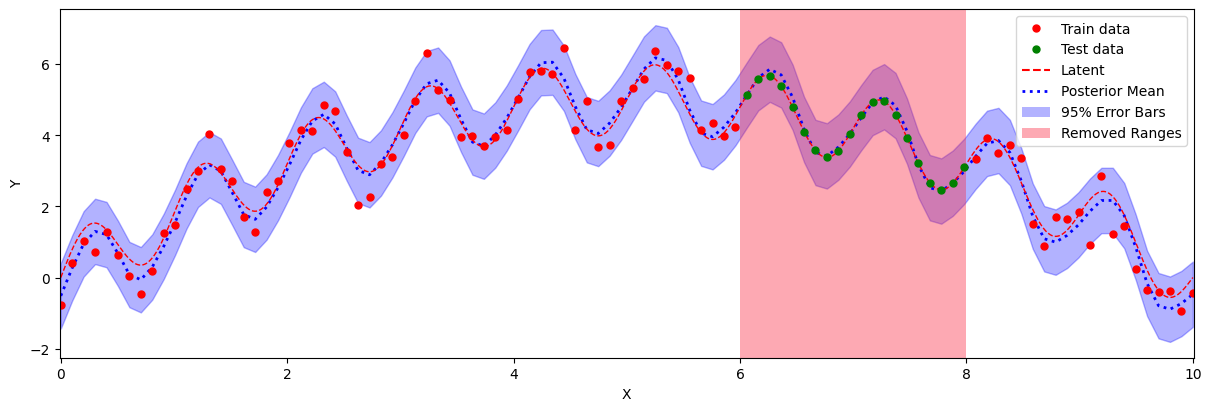

In [8]:
model.plot_prediction()
mogptk.error(model, disp=True)

The trained parameters for the coefficients are close to the used values for creating the data set (`[0.0, 2.0, -0.2]`). Also note that the `IMO.noise` parameter is (usually) close to `0.5`. There are two `noise` parameters, one for the entire model and one for each channel of [`IndependentMultiOutputKernel`](https://games-uchile.github.io/mogptk/gpr/multioutput.html#mogptk.gpr.multioutput.IndependentMultiOutputKernel) (IMO). The latter allows training different noises per channel which makes the model-wide noise redundant, thus it is fixed to zero.

In [9]:
model.print_parameters()

Name,Range,Value
IndependentMultiOutputKernel[0].PeriodicKernel.magnitude,"[1e-08, ∞)",1.2174491000055625
IndependentMultiOutputKernel[0].PeriodicKernel.period,"[1e-08, ∞)",[1.00042073]
IndependentMultiOutputKernel[0].PeriodicKernel.lengthscale,"[1e-08, ∞)",[1.74552524]
Mean.coefficients,"(-∞, ∞)",[-0.43433419 2.22224111 -0.221538 ]
GaussianLikelihood.scale,"[1e-08, ∞)",[0.44589651]
